# Ensemble Learning of a Hidden Markov Model

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating new project at `C:\Users\the_m\github\activeInference\julia`


In this demo we are interested in Bayesian inference of parameters of a hidden Markov model (HMM).,
Specifically, we consider a first-order HMM with hidden states $s_0, s_1, \dots, s_T$ and observations $x_1, \dots, x_T$ governed by a state transition probability matrix $A$ and an observation probability matrix $B$:

$$\begin{aligned}
    s_t & \sim \mathcal{C}at(A s_{t-1}),\\
    x_t & \sim \mathcal{C}at(B s_t).\\
\end{aligned}$$


We assume three possible states (\"red\", \"green\" and \"blue\"), and the goal is to estimate matrices $A$ and $B$ from a simulated data set. To have a full Bayesian treatment of the problem, both $A$ and $B$ are endowed with priors (Dirichlet distributions on the columns)."

In [3]:
using RxInfer, Random, BenchmarkTools, Distributions, LinearAlgebra, Plots

In [4]:
function rand_vec(rng, distribution::Categorical) 
    k = ncategories(distribution)
    s = zeros(k)
    s[ rand(rng, distribution) ] = 1.0
    s
end

function generate_data(n_samples; seed = 124)
    
    rng = MersenneTwister(seed)
    
    # Transition probabilities (some transitions are impossible)
    A = [0.9 0.0 0.1; 0.1 0.9 0.0; 0.0 0.1 0.9] 
    # Observation noise
    B = [0.9 0.05 0.05; 0.05 0.9 0.05; 0.05 0.05 0.9] 
    # Initial state
    s_0 = [1.0, 0.0, 0.0] 
    # Generate some data
    s = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the states
    x = Vector{Vector{Float64}}(undef, n_samples) # one-hot encoding of the observations
    
    s_prev = s_0
    
    for t = 1:n_samples
        a = A * s_prev
        s[t] = rand_vec(rng, Categorical(a ./ sum(a)))
        b = B * s[t]
        x[t] = rand_vec(rng, Categorical(b ./ sum(b)))
        s_prev = s[t]
    end
    
    return x, s
end

generate_data (generic function with 1 method)

In [5]:
# Test data
N = 100
x_data, s_data = generate_data(N);

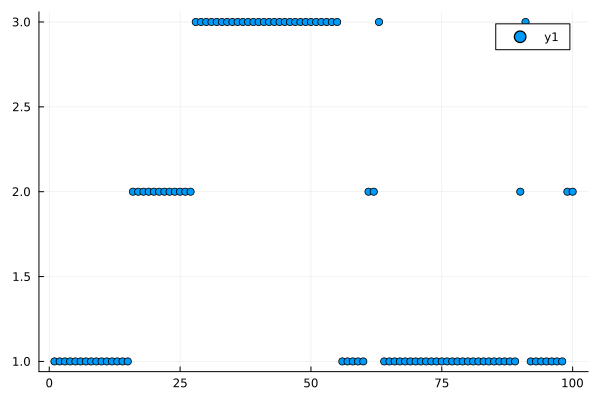

In [6]:
scatter(argmax.(s_data))

In [7]:
# Model specification
@model function hidden_markov_model(n)
    
    A ~ MatrixDirichlet(ones(3, 3)) 
    B ~ MatrixDirichlet([ 10.0 1.0 1.0; 1.0 10.0 1.0; 1.0 1.0 10.0 ])
    
    s_0 ~ Categorical(fill(1.0 / 3.0, 3))
    
    s = randomvar(n)
    x = datavar(Vector{Float64}, n)
    
    s_prev = s_0
    
    for t in 1:n
        s[t] ~ Transition(s_prev, A) 
        x[t] ~ Transition(s[t], B)
        s_prev = s[t]
    end
    
end

@constraints function hidden_markov_model_constraints()
    q(s_0, s, A, B) = q(s_0, s)q(A)q(B)
end

hidden_markov_model_constraints (generic function with 1 method)

In [ ]:
idata = (x = x_data, )

imodel = hidden_markov_model(N)

imarginals = (
    A = vague(MatrixDirichlet, 3, 3), 
    B = vague(MatrixDirichlet, 3, 3), 
    s = vague(Categorical, 3)
)

ireturnvars = (
    A = KeepLast(),
    B = KeepLast(),
    s = KeepLast()
)

result = inference(
    model         = imodel, 
    data          = idata,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = imarginals, 
    returnvars    = ireturnvars, 
    iterations    = 20, 
    free_energy   = true
);

In [ ]:
mean(result.posteriors[:A])

In [ ]:
mean(result.posteriors[:B])

In [ ]:
p1 = scatter(argmax.(s_data), title="Inference results", label = "real", ms = 6)
p1 = scatter!(p1, argmax.(ReactiveMP.probvec.(result.posteriors[:s])), label = "inferred", ms = 2)
p2 = plot(result.free_energy, label="Free energy")

plot(p1, p2, layout = @layout([ a; b ]))

# Benchmark timings

In [ ]:
@benchmark inference(
    model         = $imodel, 
    data          = $idata,
    constraints   = hidden_markov_model_constraints(),
    initmarginals = $imarginals, 
    returnvars    = $ireturnvars, 
    iterations    = 20, 
    free_energy   = true
)